# Spotify Popularity Predictor

## Project Goals
Discover drivers of popularity.
Predict the popularity of songs based on user's top artists.

## Project Description
This project utilizes a user's Spotify data to retrieve the discography of each artist in the user's top artists, analyzes audio features, creates clusters based on similar features, and then uses machine learning to create a regression model that predicts the popularity of each song.

## Initial Questions
1. Can meaningful clusters be created from Spotify's audio features?
2. Does a song's dancability correlate with popularity?
3. Does a song's tempo correlate with popularity?
4. Does a song's key and mode correlate with popularity?

## Data Dictionary
| variable      | meaning       |
| ------------- |:-------------:|
|popularity|target value: Popularity of the artist, calculated by popularity of all artist's tracks|
|lm|Ordinary Least Squares Linear Regression modeling algorithm|
|lm2|Polynomial Regression modeling algorithm |
|glm|TweedieRegressor modeling algorithm|
|Audio Features|
|acousticness|confidence measure of whether the track is acoustic|
|danceability|how suitable a track is for dancing|
|duration_minutes|duration of track in minutes, rounded to the nearest whole minute|
|energy|perceptual measure of intensity and activity|
|instrumentalness|predicts whether a track contains no vocals|
|key|the key the track is in|
|liveness|presence of an audience in the recording|
|loudness|overall loudness of a track in decibels|
|mode|indicates modality, with 1 being major and 0 being minor|
|speechiness|presence of spoken words in a track, with 1 being a talk show or podcast|
|tempo|overall estimated pace of a track in beats per minute|
|time_signature|estimated meter of beats in a bar, ranging from 3/4 to 7/4|
|valence|measure of how positive a song sounds|

## Wrangling Spotify Data
Utilizing Spotify's Web API and the spotipy library, a dataframe is made using the user's top artists' discographies. The song URI is used to pull their audio features and are then merged onto the dataframe.

In [1]:
# import modules
import pandas as pd

#import visualizations
import viz

# ignore warnings to reduce clutter
import warnings
warnings.filterwarnings("ignore")

# Import wrangle module with functions to acquire, prepare, scale, and split data from Spotify's API
import wrangle

# execute functions to acquire and split a df and store in train, validate, and test dataframes
df = wrangle.get_spotify_top_artists_discography_data()
train, validate, test = wrangle.split_data(df)
scaler, train_scaled, validate_scaled, test_scaled = wrangle.standard_scaler(train, validate, test)

Data preparation is executed by:
- Converting duration_ms to duration_minutes
- Ensuring no nulls are in the data
- Dropping duplicate values

## Data Landscape
- Discographies from 860 artists
- 15K songs
- 13 audio features

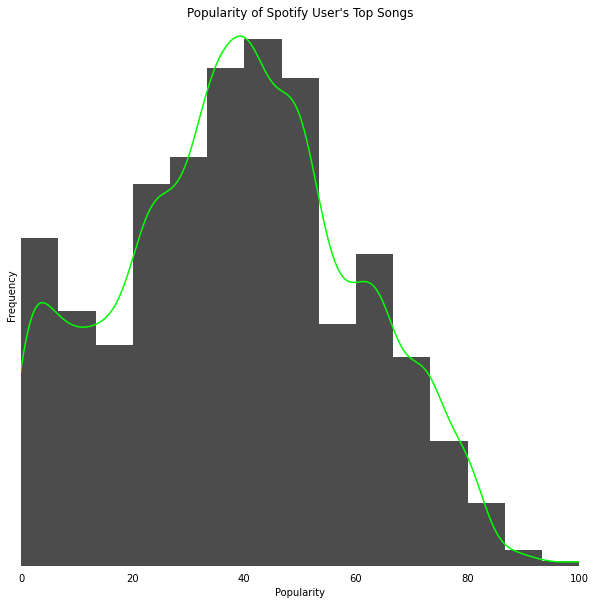

In [2]:
viz.data_landscape(df)

## Clustering
Clusters are created with KMeans using scaled data.

### What clusters make sense?
Clusters are created based on features that relate to eachother musically.

- beat_cluster: tempo, energy, danceability

- mood_cluster: mode, key, and valence

- ambience_cluster: acousticness, intrumentalness, loudness

The number of clusters (k) was found using the elbow method.

### Beat Cluster
tempo, energy, and danceability

In [3]:
# import clustering module
from sklearn.cluster import KMeans

# define features for clustering
X_train_beat_cluster = train_scaled[['tempo','energy','danceability']]
X_validate_beat_cluster = validate_scaled[['tempo','energy','danceability']]
X_test_beat_cluster = test_scaled[['tempo','energy','danceability']]

# define cluster object
kmeans = KMeans(n_clusters=4, random_state = 222)
# fit cluster object to features
kmeans.fit(X_train_beat_cluster)
# use the object
train_scaled['beat_cluster'] = kmeans.predict(X_train_beat_cluster)
validate_scaled['beat_cluster'] = kmeans.predict(X_validate_beat_cluster)
test_scaled['beat_cluster'] = kmeans.predict(X_test_beat_cluster)
X_train_beat_cluster['beat_cluster'] = kmeans.predict(X_train_beat_cluster)


#define centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_beat_cluster.loc[:, X_train_beat_cluster.columns != 'beat_cluster'].columns)

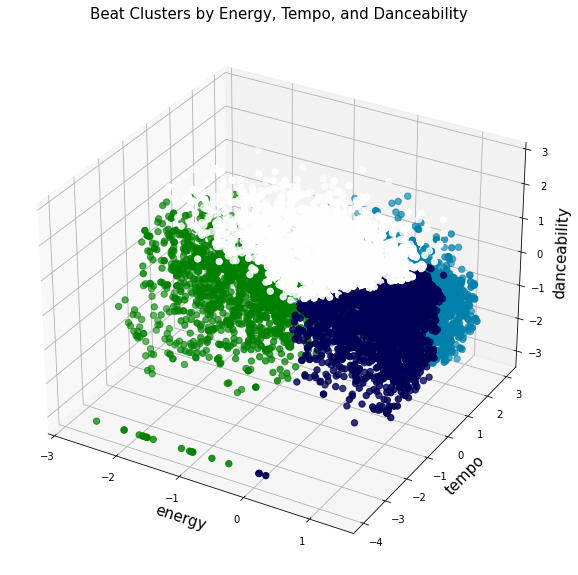

In [4]:
viz.beat_cluster(X_train_beat_cluster, centroids)


This cluster has four definitive clusters and may be used in modeling.

### Mood Cluster
mode, key, and valence

In [5]:
# define features for clustering
X_train_mood_cluster = train_scaled[['mode','key','valence']]
X_validate_mood_cluster = validate_scaled[['mode','key','valence']]
X_test_mood_cluster = test_scaled[['mode','key','valence']]

# define cluster object
kmeans = KMeans(n_clusters=4, random_state = 222)
# fit cluster object to features
kmeans.fit(X_train_mood_cluster)
# use the object
train_scaled['mood_cluster'] = kmeans.predict(X_train_mood_cluster)
validate_scaled['mood_cluster'] = kmeans.predict(X_validate_mood_cluster)
test_scaled['mood_cluster'] = kmeans.predict(X_test_mood_cluster)
X_train_mood_cluster['mood_cluster'] = kmeans.predict(X_train_mood_cluster)


#define centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_mood_cluster.loc[:, X_train_mood_cluster.columns != 'mood_cluster'].columns)

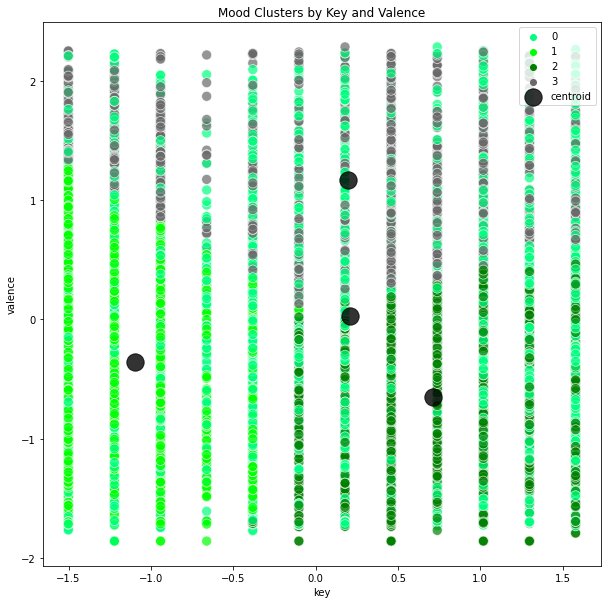

In [6]:
viz.mood_cluster(X_train_mood_cluster, centroids)


This cluster has a lot of overlap and might not be useful in modeling.

### Ambience Cluster
acousticness, intrumentalness, loudness

In [7]:
# define features for clustering
X_train_ambience_cluster = train_scaled[['acousticness','instrumentalness','loudness']]
X_validate_ambience_cluster = validate_scaled[['acousticness','instrumentalness','loudness']]
X_test_ambience_cluster = test_scaled[['acousticness','instrumentalness','loudness']]

# define cluster object
kmeans = KMeans(n_clusters=4, random_state = 222)
# fit cluster object to features
kmeans.fit(X_train_ambience_cluster)
# use the object
train_scaled['ambience_cluster'] = kmeans.predict(X_train_ambience_cluster)
validate_scaled['ambience_cluster'] = kmeans.predict(X_validate_ambience_cluster)
test_scaled['ambience_cluster'] = kmeans.predict(X_test_ambience_cluster)
X_train_ambience_cluster['ambience_cluster'] = kmeans.predict(X_train_ambience_cluster)


#define centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_ambience_cluster.loc[:, X_train_ambience_cluster.columns != 'ambience_cluster'].columns)

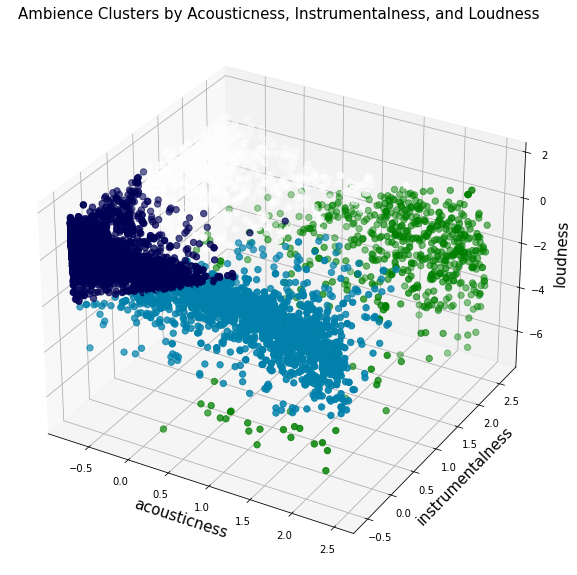

In [8]:
viz.ambience_cluster(X_train_ambience_cluster, centroids)


This cluster has four definitive clusters and may be used in modeling.

### Clustering Summary

The mood clusters have too much overlap to be useful, I expect this is because the features included are mostly categorical in nature.

The beat and ambience clusters have a pretty distinct split. Statistical tests  will evaluate correlation with popularity.

## Exploratory Analysis
### What correlates with popularity?
Beat clusters, ambience clusters, and audio features correlations with popularity are assessed.

In [9]:
# import statistics module and establish alpha
from scipy import stats
alpha = 0.5

1. Is popularity different between clusters based on house features?

Run anova test
$H:0$
: Means of the logerror between clusters are equal

H
a
 Means of the logerror between clusters are not equal

In [10]:
x = train_scaled.beat_cluster
y = train_scaled.popularity

corr, p = stats.pearsonr(x, y)

if p < alpha:
    print('There is a correlation between beat clusters and popularity')
else:
    print('There is no correlation between beat clusters and popularity')

There is a correlation between beat clusters and popularity


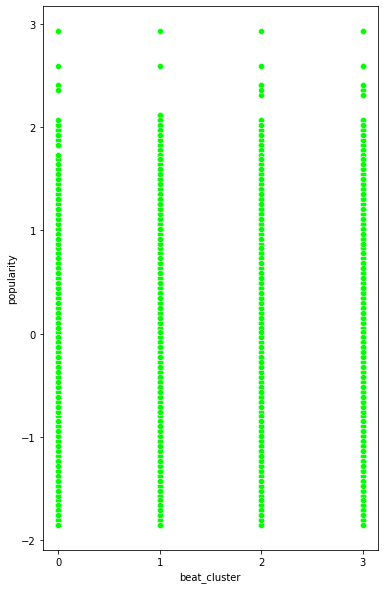

In [11]:
viz.stats_beat(train_scaled)

In [12]:
x = train_scaled.ambience_cluster
y = train_scaled.popularity

corr, p = stats.pearsonr(x, y)

if p < alpha:
    print('There is a correlation between ambience clusters and popularity')
else:
    print('There is no correlation between ambience clusters and popularity')

There is a correlation between ambience clusters and popularity


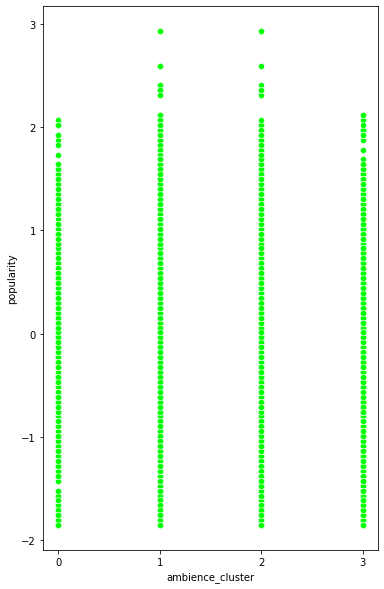

In [13]:
viz.stats_ambience(train_scaled)

In [14]:
x = train_scaled.danceability
y = train_scaled.popularity

corr, p = stats.pearsonr(x, y)

if p < alpha:
    print('There is a correlation between danceability and popularity')
else:
    print('There is no correlation between danceability and popularity')

There is a correlation between danceability and popularity


<Figure size 720x720 with 0 Axes>

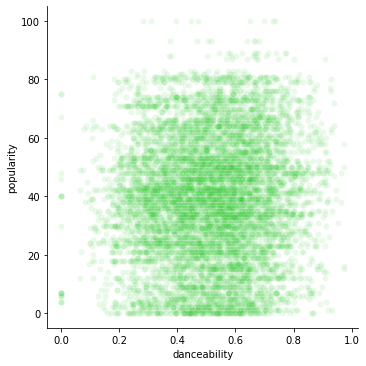

In [15]:
viz.stats_danceability(train)

In [16]:
x = train_scaled.loudness
y = train_scaled.popularity

corr, p = stats.pearsonr(x, y)

if p < alpha:
    print('There is a correlation between loudness and popularity')
else:
    print('There is no correlation between loudness and popularity')

There is a correlation between loudness and popularity


<Figure size 720x720 with 0 Axes>

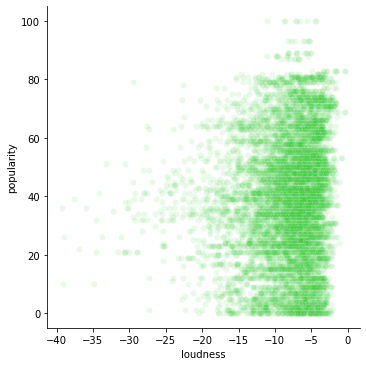

In [17]:
viz.stats_loudness(train)

### SelectKBest
Features that have the strongest correlations with the target.

In [18]:
X_train = train_scaled.drop(columns = 'popularity')
y_train = train_scaled['popularity']

from sklearn.feature_selection import SelectKBest, f_regression

# our selecter is an f_regression stats test and retrieving 10 features
f_selector = SelectKBest(f_regression, k=10)

# find the top 5 features correlated with our target
f_selector.fit(X_train, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top features. 
f_feature = X_train.iloc[:,feature_mask].columns.tolist()

f_feature

['danceability',
 'loudness',
 'mode',
 'instrumentalness',
 'liveness',
 'valence',
 'time_signature',
 'beat_cluster',
 'mood_cluster',
 'ambience_cluster']

### Exploration Takeaways
Statistical analysis shows correlation between the clusters and target, as well as the audio features and target. All features can be used in modeling. SelectKBest's recommendation is also considered.

## Modeling: Predicting Popularity
Popularity is a continuous target, so linear regression algorithms are used to create models. The models are fit on a training dataset then validated against a separate dataset to ensure no overfitting takes place. The primary measure for performance used is RMSE.

In [19]:
#import linear regression modules
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

#import evaluation metrics
from sklearn.metrics import mean_squared_error

### Create X and y variables for modeling

In [20]:
# Create X and y for train, validate, test with no feature mask.
X_train = train_scaled.drop(columns=['popularity'])
y_train = train['popularity']

X_validate = validate_scaled.drop(columns=['popularity'])
y_validate = validate['popularity']

X_test = test_scaled.drop(columns=['popularity'])
y_test = test['popularity']

### Baseline
A baseline is created using the mean popularity and evaluated against actual popularity, establishing a goal for the models to beat the RMSE of the baseline.

In [21]:
# Create dataframes of the target for modeling purposes
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# predict mean
pred_mean = y_train.popularity.mean()
y_train['baseline_pred_mean'] = pred_mean
y_validate['baseline_pred_mean'] = pred_mean

# RMSE of mean
rmse_train = mean_squared_error(y_train.popularity, y_train.baseline_pred_mean)**(1/2)
print("Train/In-Sample RMSE: ", rmse_train)

# validate rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.baseline_pred_mean)**(1/2)
print("Validate/Out-of-Sample RMSE: ", rmse_validate)
baseline_rmse = rmse_validate
# df with all RMSE
model_eval = pd.DataFrame([{'baseline':rmse_validate}])

Train/In-Sample RMSE:  20.908177508167526
Validate/Out-of-Sample RMSE:  20.863228238756907


## Model 1: OLS All Features

In [22]:
# Create model
lm = LinearRegression(normalize=True,)

# fit the model to training data.
lm.fit(X_train, y_train.popularity)

# predict train
y_train['popularity_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_lm)**(1/2)

print("Training/In-Sample RMSE: ", rmse_train)

Training/In-Sample RMSE:  20.554756973148812


### Evaluate on Validate

In [23]:
# predict validate
y_validate['popularity_pred_lm'] = lm.predict(X_validate)

# evaluate rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_lm)**(1/2)

print("Validation/Out-of-Sample RMSE:", rmse_validate)

model_eval['ols'] = rmse_validate

Validation/Out-of-Sample RMSE: 20.48823991897618


## Model 2: GLM All Features

In [24]:
# create the model object
glm = TweedieRegressor(power = 0, alpha=0.5)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.popularity)

# predict train
y_train['popularity_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train) 

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  20.622925624252296


### Evaluate on Validate

In [25]:
# predict validate
y_validate['popularity_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_glm)**(1/2)

print("Validation/Out-of-Sample: ", rmse_validate)
model_eval['glm'] = rmse_validate

Validation/Out-of-Sample:  20.532898277023566


## Model 3: Polynomial Model All Features

In [26]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate & X_test
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data.
lm2.fit(X_train_degree2, y_train.popularity)

# predict train
y_train['popularity_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  20.198558318740947


### Evaluate on Validate

In [27]:
# predict validate
y_validate['popularity_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_lm2)**(1/2)

print('Validation/Out-of-Sample:', rmse_validate)
model_eval['lm2'] = rmse_validate


Validation/Out-of-Sample: 20.326966988677743


Model Evaluation:

In [28]:
model_eval

,baseline,ols,glm,lm2
0,20.863228,20.48824,20.532898,20.326967


The polynomial model with all features and clusters included is the best performing model, beating the baseline by 2.57%.

## Validate with Visuals

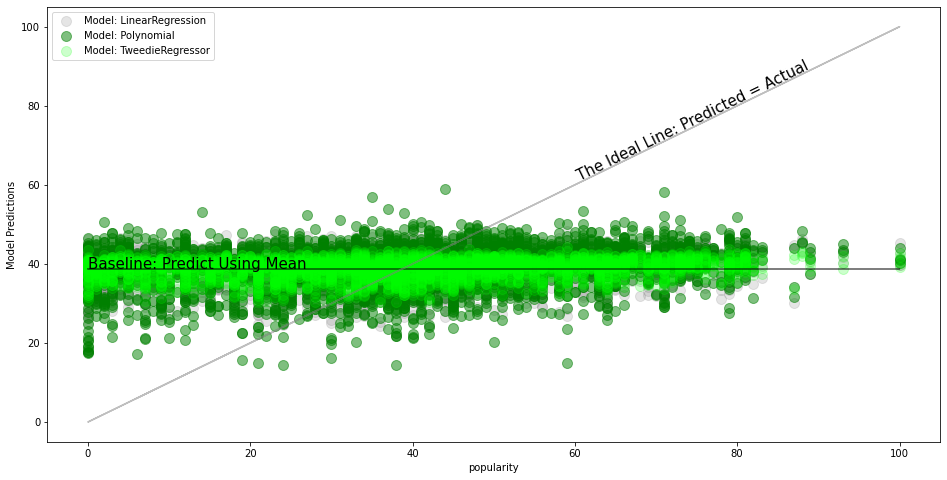

In [29]:
viz.validate_residuals(y_validate)

The polynomial model is slightly more fit to the ideal line.

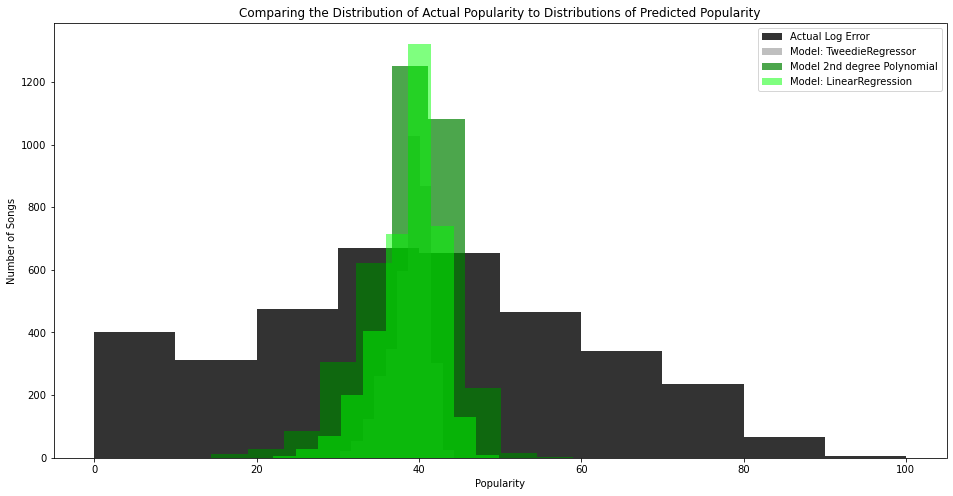

In [30]:
viz.validate_hist(y_validate)

The polynomial model histogram is also slightly more fit to actual predictions.

## Evaluate on Test

In [31]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['popularity_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.popularity, y_test.popularity_pred_lm2)**(1/2)

print("Out-of-Sample Performance RMSE: ", rmse_test)
lm2_test_rmse = rmse_test

Out-of-Sample Performance RMSE:  20.571929953911248


Evaluating on the test dataset, the Polynomial Model beats baseline by 1.4%

# Conclusion
## Key takeaways:
### Features that matter?
The features that matter the most are danceability, loudness, and mode. This means that if a song is danceable, loud, and in a major key, the more likely it is going to be more popular.

### Modeling
The data was modeled through several regression algorithms. The polynomial model with all features included was the top performer with an RMSE of 20.57 when evaluated on the test dataset, beating the baseline RMSE by 1.4%.

## Recommendations:
When modeling top artist popularity per user, the artists included may not have a high popularity ranking. Including a more broad generic dataset will provide consistency and variety in modeling, especially to users who don't listen to as much popular music.

## Next Steps:
Acquire data on Spotify's top 100 artists and their songs, building a model with a more clear reference for what is popular before deploying the model to top artists of specific users.